In [9]:
print("Starting imports")
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import datetime

print("Setting up paths")
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
models_path = Path.cwd().parent
if str(models_path) not in sys.path:
    sys.path.append(str(models_path))
    
print("Importing torch")
from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch
import torch.nn.functional as F
    
print("Importing custom modules")
from dataset.IntersectionDataset import IntersectionDatasetClasses, custom_collate_fn
import loss.loss_lib as ll
import loss.topo_lib as tl

# ================= Datasets =====================
print("Setting up datasets")

dataset_dir = "../../dataset/dataset/train"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_train = IntersectionDatasetClasses(root_dir=dataset_dir, 
                                    transform=img_transform,
                                    path_transform=path_transform)

dataset_dir = "../../dataset/dataset/test"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_test = IntersectionDatasetClasses(root_dir=dataset_dir,
                                   transform=img_transform,
                                   path_transform=path_transform)
#print(len(dataset_train))
#print(len(dataset_test))

num_workers = multiprocessing.cpu_count()
b = 1

train_dataloader = DataLoader(dataset_train, batch_size=b, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=b, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)

# ====================== Names ======================

file_name = "c_deeplab_05_26_100_cmap-ce_adamw_cos"
print(f"Importing and instantiating {file_name}")

try:
    del(model)
except:
    pass

ckpt_path = f"/mnt/e/msc_checkpoints/{file_name}.pth"
ckpt = torch.load(ckpt_path)

if "deeplab" in file_name:
    import deeplabv3.Deeplabv3 as d
    model_name = "deeplab"
elif "unet" in file_name:
    import unet.Unet as u
    model_name = "unet"
elif "vit" in file_name:
    import vit.Vit as v
    model_name = "vit"
elif "swin" in file_name:
    import swin.Swin as s
    model_name = "swin"
else:
    raise ValueError("Model type not recognized in file name.")

if "ce" in file_name:
    if "topo" in file_name:
        loss_fn = "ce-topo"
    elif "cmap" in file_name:
        loss_fn = "ce-cmap"
    else:
        loss_fn = "ce"
else:
    if "topo" in file_name:
        loss_fn = "topo"
    elif "cmap" in file_name:
        loss_fn = "cmap"
    else:
        raise ValueError("Loss function not recognized in file name.")

loss_fn = "cmap-ce" # FORCE
optimizer_name = "adamw"
scheduler_name = "cos"

# ====================== Model ======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
match model_name:
    case "deeplab":
        model = d.DeepLabV3().to(device) 
        model.load_state_dict(ckpt['model_state_dict'])
    case "unet":
        model = u.UNet().to(device)
        model.load_state_dict(ckpt['model_state_dict'])
    case "vit":
        model = v.ViT().to(device)
        model.load_state_dict(ckpt['model_state_dict'])
    case "swin":
        model = s.Swin().to(device)
        model.load_state_dict(ckpt['model_state_dict'])
    case _:
        raise ValueError("Model type not recognized.")

model.eval()

base = f"{model_name}_{loss_fn}_e{len(ckpt['train_losses'])}"
res_folder = f"../results"
    
print(f"{model_name} ready")

Starting imports
Setting up paths
Importing torch
Importing custom modules
Setting up datasets
Importing and instantiating c_deeplab_05_26_100_cmap-ce_adamw_cos
deeplab ready


In [ ]:
#mIoU
def mIoU(pred, target, num_classes):
    # pred: (H, W), target: (H, W, 1)
    pred = pred.flatten()
    target = target.squeeze(-1).flatten()  # remove last dim if present

    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for i in range(num_classes):
        intersection[i] = np.sum((pred == i) & (target == i))
        union[i] = np.sum((pred == i) | (target == i))

    # Avoid division by zero
    iou = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union != 0)
    miou = np.mean(iou)

    return miou

def mIoU_per_class(pred, target, num_classes):
    # pred: (H, W), target: (H, W, 1)
    pred = pred.flatten()
    target = target.squeeze(-1).flatten()  # remove last dim if present

    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for i in range(num_classes):
        intersection[i] = np.sum((pred == i) & (target == i))
        union[i] = np.sum((pred == i) | (target == i))

    # Avoid division by zero
    iou = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union != 0)

    return iou

# Test 1

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

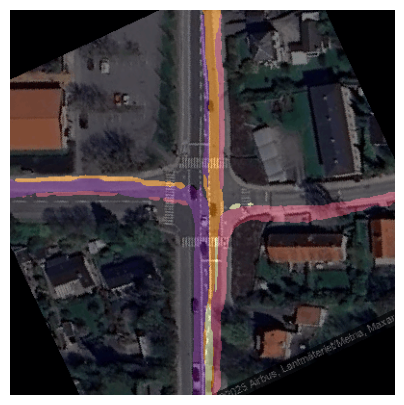

In [8]:
test_1_index = 8
satellite = test_dataloader.dataset[test_1_index]['satellite'].to(device)
fig = plt.figure(figsize=(5, 5))
plt.imshow(satellite.cpu().numpy().transpose(1, 2, 0))

output = model(satellite.unsqueeze(0))
output = torch.argmax(output, dim=1)
output = output.squeeze(0).cpu().numpy()

plt.imshow(output, cmap='inferno', alpha=0.5, vmin=0, vmax=4)

plt.axis('off')

#plt.savefig(f"{res_folder}/{base}_test1.png", bbox_inches='tight', transparent=True)

# Test 2

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

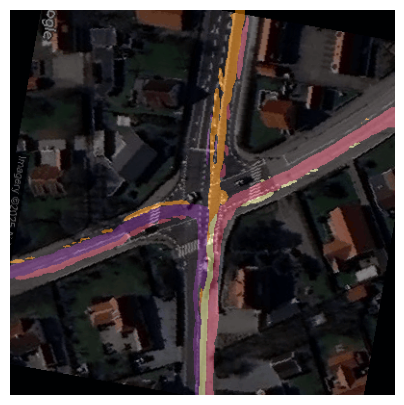

In [3]:
test_2_index = 14
satellite = test_dataloader.dataset[test_2_index]['satellite'].to(device)
fig = plt.figure(figsize=(5, 5))
plt.imshow(satellite.cpu().numpy().transpose(1, 2, 0))

output = model(satellite.unsqueeze(0))
output = torch.argmax(output, dim=1)
output = output.squeeze(0).cpu().numpy()

plt.imshow(output, cmap='inferno', alpha=0.5, vmin=0, vmax=4)

plt.axis('off')

#plt.savefig(f"{res_folder}/{base}_test2.png", bbox_inches='tight', transparent=True)

# Train 1

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

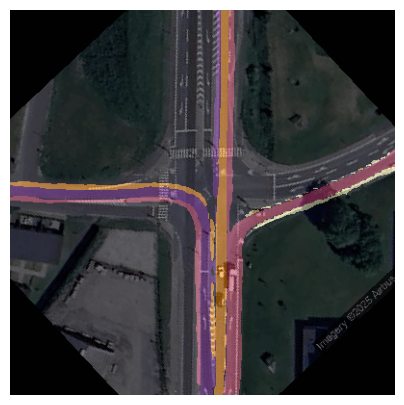

In [4]:
train_1_index = 0
satellite = train_dataloader.dataset[train_1_index]['satellite'].to(device)
fig = plt.figure(figsize=(5, 5))
plt.imshow(satellite.cpu().numpy().transpose(1, 2, 0))

output = model(satellite.unsqueeze(0))
output = torch.argmax(output, dim=1)
output = output.squeeze(0).cpu().numpy()

plt.imshow(output, cmap='inferno', alpha=0.5, vmin=0, vmax=4)

plt.axis('off')

#plt.savefig(f"{res_folder}/{base}_train1.png", bbox_inches='tight', transparent=True)



# Train graph

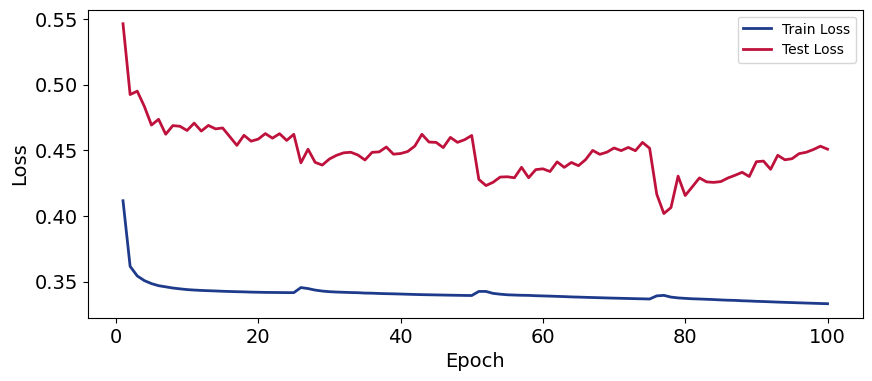

In [5]:
n_epochs = len(ckpt['train_losses'])
train_losses = ckpt['train_losses']
test_losses = ckpt['test_losses']
# Plotting the loss graphs
plt.figure(figsize=(10, 4))
plt.plot(range(1, n_epochs + 1), train_losses, label="Train Loss", color='#1e3a8a', linewidth=2)
plt.plot(range(1, n_epochs + 1), test_losses, label="Test Loss", color = "#be123c", linewidth=2)
plt.xlabel("Epoch", size=14)
plt.ylabel("Loss", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
#plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
#plt.savefig(f"{res_folder}/{model_name}_{loss_fn}_train_graph.png", bbox_inches='tight', transparent=True)
plt.show()

# Validation Graph

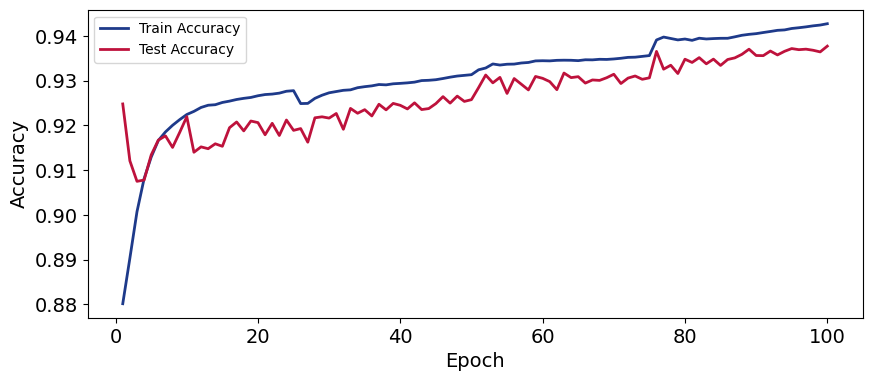

In [6]:
n_epochs = len(ckpt['train_losses'])
train_accuracies = ckpt['train_accuracies']
test_accuracies = ckpt['test_accuracies']
plt.figure(figsize=(10, 4))
train_accuracies_normalized = [acc / (400**2) for acc in train_accuracies]
test_accuracies_normalized = [acc / (400**2) for acc in test_accuracies]
plt.plot(range(1, n_epochs + 1), train_accuracies_normalized, label="Train Accuracy", color='#1e3a8a', linewidth=2)
plt.plot(range(1, n_epochs + 1), test_accuracies_normalized, label="Test Accuracy", color='#be123c', linewidth=2)
plt.xlabel("Epoch", size=14)
plt.ylabel("Accuracy", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
#plt.title("Training and Evaluation Accuracy Over Epochs")
#plt.savefig(f"{res_folder}/{model_name}_{loss_fn}_test_graph.png", bbox_inches='tight', transparent=True)
plt.legend()
plt.show()

# mIoU

In [ ]:
overall_miou = []
per_class = np.zeros((5))
N = len(test_dataloader)
for i in range(N):
    satellite = test_dataloader.dataset[i]['satellite'].to(device)
    class_labels = test_dataloader.dataset[i]['class_labels'].cpu().numpy().transpose(1, 2, 0)
    
    output = model(satellite.unsqueeze(0))
    output = torch.argmax(output, dim=1)
    output = output.squeeze(0).cpu().numpy()
    
    overall_miou.append(mIoU(output, class_labels, 5))
    per_class += mIoU_per_class(output, class_labels, 5)
    
    break
    
overall_miou = np.mean(overall_miou)
per_class = per_class / N
print(f"Overall mIoU: {overall_miou:.4f}")
print(f"Per class mIoU: {[float(f'{x:.4f}') for x in per_class]}")

In [ ]:
# satellite = test_dataloader.dataset[test_1_index]['satellite']
# fig = plt.figure(figsize=(5, 5))
# plt.imshow(satellite.numpy().transpose(1, 2, 0))
# plt.axis('off')
# plt.savefig(f"{res_folder}/satellite_test1.png", bbox_inches='tight', transparent=True)

# class_labels = test_dataloader.dataset[test_1_index]['class_labels'].cpu().numpy().transpose(1, 2, 0)
# plt.imshow(class_labels, cmap='inferno', vmin=0, vmax=4)
# plt.axis('off')
# plt.savefig(f"{res_folder}/class_labels_test1.png", bbox_inches='tight', transparent=True)

# satellite = test_dataloader.dataset[test_2_index]['satellite']
# fig = plt.figure(figsize=(5, 5))
# plt.imshow(satellite.numpy().transpose(1, 2, 0))
# plt.axis('off')
# plt.savefig(f"{res_folder}/satellite_test2.png", bbox_inches='tight', transparent=True)

# class_labels = test_dataloader.dataset[test_2_index]['class_labels'].cpu().numpy().transpose(1, 2, 0)
# plt.imshow(class_labels, cmap='inferno', vmin=0, vmax=4)
# plt.axis('off')
# plt.savefig(f"{res_folder}/class_labels_test2.png", bbox_inches='tight', transparent=True)

# satellite = train_dataloader.dataset[train_1_index]['satellite']
# fig = plt.figure(figsize=(5, 5))
# plt.imshow(satellite.numpy().transpose(1, 2, 0))
# plt.axis('off')
# plt.savefig(f"{res_folder}/satellite_train1.png", bbox_inches='tight', transparent=True)

# class_labels = train_dataloader.dataset[train_1_index]['class_labels'].cpu().numpy().transpose(1, 2, 0)
# plt.imshow(class_labels.squeeze(), cmap='inferno', vmin=0, vmax=4)
# plt.axis('off')
# plt.savefig(f"{res_folder}/class_labels_train1.png", bbox_inches='tight', transparent=True)

## Inference Time

In [ ]:
import time

In [ ]:
times = []
N = len(test_dataloader)
for i in range(N):
    satellite = test_dataloader.dataset[i]['satellite'].to(device)
    class_labels = test_dataloader.dataset[i]['class_labels'].cpu().numpy().transpose(1, 2, 0)
    
    start_time = time.time()
    output = model(satellite.unsqueeze(0))
    elapsed = (time.time() - start_time) * 1000  # convert to milliseconds
    
    times.append(elapsed)
    
times = np.array(times)
print(f"Average inference time: {np.mean(times):.2f} ms")    
    

In [ ]:
deeplab_avg_times = np.array([10.58, 10.67, 11.67, 11.10, 11.04])
unet_avg_times = np.array([4.41, 4.26, 3.86, 3.98, 4.11])
vit_avg_times = np.array([9.19, 9.20, 9.80, 9.40, 9.79])
swin_avg_times = np.array([36.09, 35.52, 37.94, 37.16, 34.75])

avg_times = np.array([np.mean(deeplab_avg_times), np.mean(unet_avg_times), np.mean(vit_avg_times), np.mean(swin_avg_times)])
print(f"Average inference times: {avg_times}")

## Ignition to First frame

In [ ]:
import time
start_time = time.time()

print("Starting imports")
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import datetime

print("Setting up paths")
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
models_path = Path.cwd().parent
if str(models_path) not in sys.path:
    sys.path.append(str(models_path))
    
from dataset.IntersectionDataset import IntersectionDatasetClasses, custom_collate_fn
    
print("Importing torch")
from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch
from torch.optim import AdamW

dataset_dir = "../../dataset/dataset/test"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_test = IntersectionDatasetClasses(root_dir=dataset_dir,
                                   transform=img_transform,
                                   path_transform=path_transform)
num_workers = multiprocessing.cpu_count()
b = 1
test_dataloader = DataLoader(dataset_test, batch_size=b, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)

    
# ====================== Names ======================

file_name = "c_swin_05_05_300_ce_adamw_cos"
print(f"Importing and instantiating {file_name}")

try:
    del(model)
except:
    pass

ckpt_path = f"/mnt/e/msc_checkpoints/{file_name}.pth"
ckpt = torch.load(ckpt_path)

if "deeplab" in file_name:
    import deeplabv3.Deeplabv3 as d
    model_name = "deeplab"
elif "unet" in file_name:
    import unet.Unet as u
    model_name = "unet"
elif "vit" in file_name:
    import vit.Vit as v
    model_name = "vit"
elif "swin" in file_name:
    import swin.Swin as s
    model_name = "swin"
else:
    raise ValueError("Model type not recognized in file name.")

if "ce" in file_name:
    if "topo" in file_name:
        loss_fn = "ce-topo"
    elif "cmap" in file_name:
        loss_fn = "ce-cmap"
    else:
        loss_fn = "ce"
else:
    if "topo" in file_name:
        loss_fn = "topo"
    elif "cmap" in file_name:
        loss_fn = "cmap"
    else:
        raise ValueError("Loss function not recognized in file name.")

optimizer_name = "adamw"
scheduler_name = "cos"

# ====================== Model ======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
match model_name:
    case "deeplab":
        model = d.DeepLabV3().to(device) 
        model.load_state_dict(ckpt['model_state_dict'])
    case "unet":
        model = u.UNet().to(device)
        model.load_state_dict(ckpt['model_state_dict'])
    case "vit":
        model = v.ViT().to(device)
        model.load_state_dict(ckpt['model_state_dict'])
    case "swin":
        model = s.Swin().to(device)
        model.load_state_dict(ckpt['model_state_dict'])
    case _:
        raise ValueError("Model type not recognized.")

model.eval()

base = f"{model_name}_{loss_fn}_e{len(ckpt['train_losses'])}"
res_folder = f"../results/{model_name}"
    
print(f"{model_name} ready")

test_1_index = 8
satellite = test_dataloader.dataset[test_1_index]['satellite'].to(device)

output = model(satellite.unsqueeze(0))

end_time = time.time()
elapsed = (end_time - start_time) * 1000  # convert to milliseconds
print(f"Total time taken: {elapsed:.2f} ms")

In [ ]:
deeplab_avg_times = np.array([4209.10, 4135.37, 4096.96, 4098.73, 4275.51])
unet_avg_times = np.array([4725.36, 3743.58, 3854.67, 3811.89, 3803.26])
vit_avg_times = np.array([9057.82, 7775.64, 10650.77, 7679.04, 7536.81])
swin_avg_times = np.array([13944.17, 8890.22, 11857.28, 8910.68, 11932.39])

avg_times = np.array([np.mean(deeplab_avg_times), np.mean(unet_avg_times), np.mean(vit_avg_times), np.mean(swin_avg_times)])
print(f"Average inference times: {avg_times}")

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {pytorch_total_params:,}")

In [ ]:
param_size_bytes = 0
for param in model.parameters():
    param_size_bytes += param.nelement() * param.element_size()

param_size_megabytes = param_size_bytes / (1024 * 1024)
print(f"Model Parameters Size: {param_size_megabytes:.2f} MB")

# You can also check buffers (e.g., running_mean, running_var in BatchNorm)
buffer_size_bytes = 0
for buffer in model.buffers():
    buffer_size_bytes += buffer.nelement() * buffer.element_size()

buffer_size_megabytes = buffer_size_bytes / (1024 * 1024)
print(f"Model Buffers Size: {buffer_size_megabytes:.2f} MB")

total_static_size_mb = param_size_megabytes + buffer_size_megabytes
print(f"Total Static Model Size (Parameters + Buffers): {total_static_size_mb:.2f} MB")

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device) # Move model to GPU

    # Example input (adjust to your model's input)
    #dummy_input = torch.randn(16, 3, 224, 224).to(device) # Batch size 16

    # Memory before forward pass
    print(f"Initial allocated memory: {torch.cuda.memory_allocated(device) / (1024*1024):.2f} MB")
    print(f"Initial reserved memory: {torch.cuda.memory_reserved(device) / (1024*1024):.2f} MB")

    # Perform a forward and backward pass (if training)
    
    output = model(satellite.unsqueeze(0))
    loss = output.sum()
    loss.backward()
    optimizer.step()

    # Memory after operations
    print(f"Allocated memory after fwd/bwd: {torch.cuda.memory_allocated(device) / (1024*1024):.2f} MB")
    print(f"Reserved memory after fwd/bwd: {torch.cuda.memory_reserved(device) / (1024*1024):.2f} MB")
    print(f"Max memory allocated: {torch.cuda.max_memory_allocated(device) / (1024*1024):.2f} MB") # Peak allocated
    print(f"Max memory reserved: {torch.cuda.max_memory_reserved(device) / (1024*1024):.2f} MB")   # Peak reserved by caching allocator

    # For a more detailed snapshot:
    print(torch.cuda.memory_summary(device))

    # Reset peak stats if you want to measure for another section
    torch.cuda.reset_peak_memory_stats(device)
else:
    print("CUDA is not available.")

In [ ]:
torch.save(model.state_dict(), f"model.pth")
model_file_size = os.path.getsize("model.pth") / (1024 * 1024)
print(f"Model file size: {model_file_size:.2f} MB")